Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()

Берем следующие ряды:

In [3]:
dowjones_closing = pd.read_csv("../data/Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("../data/Series/daily-total-female-births-in-cal.csv")

По предыдущему дз помним что первый ряд не является стационарным, второй является.

#### Weekly closings of the Dow-Jones industrial average

In [4]:
series = dowjones_closing.Close

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


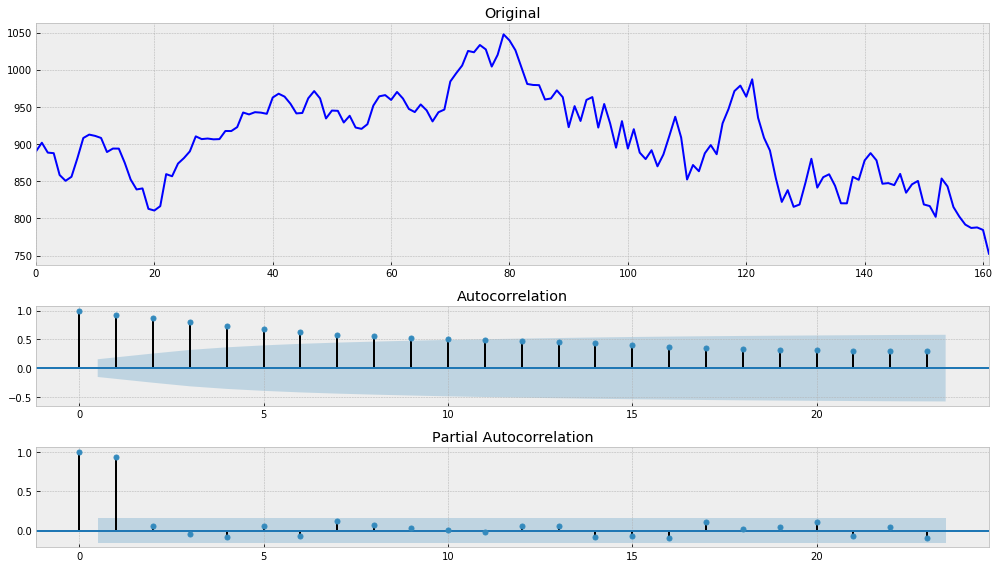

In [5]:
tsplot(series)

В ряде не замечена сезонная компонента, значит можно применить модель без этой компоненты. Попробуем взять двойное экспоненциальное сглаживание

In [6]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [7]:
def plot_dema(series, alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

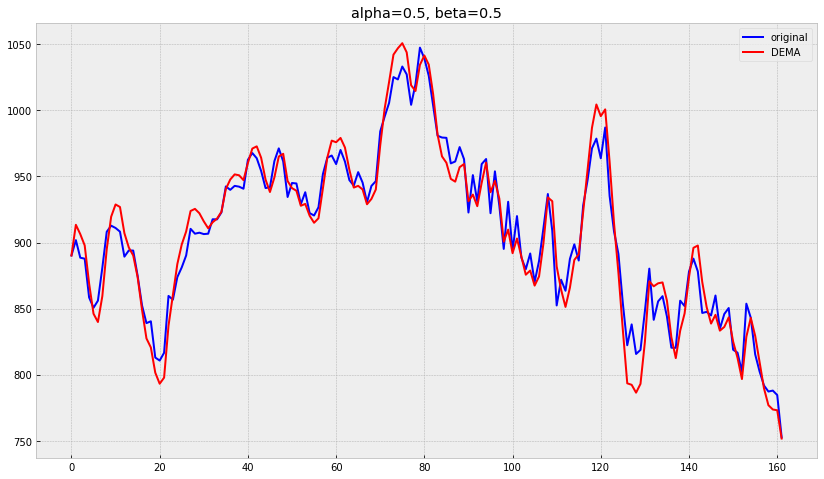

In [8]:
plot_dema(series, 0.5, 0.5)

Подберем параметры модели, в качестве метрики качества возьмем стандартный RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

In [9]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [10]:
def dema_mse(X):
    alpha, beta = X
    result = double_ema(series, alpha, beta)
    error = mean_squared_error(series, result)
    return error

In [11]:
opt = minimize(dema_mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [12]:
opt

      fun: 12.42118319328804
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.37507799e-06, -2.04281037e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 19
   status: 0
  success: True
        x: array([0.98398901, 0.06019621])

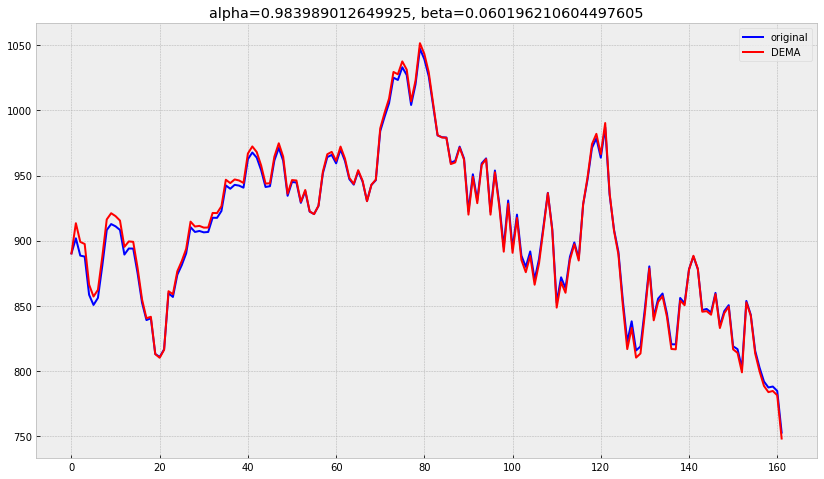

In [13]:
plot_dema(series, opt.x[0], opt.x[1])

In [14]:
print("RMSE:", opt.fun)

RMSE: 12.42118319328804


#### Daily total female births in California

In [15]:
series = female_births.Count

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


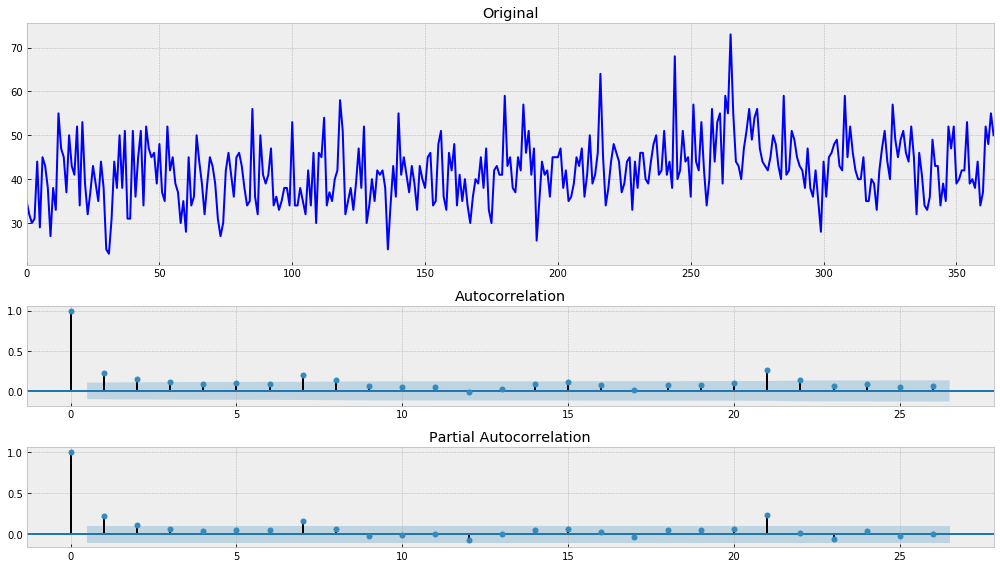

In [16]:
tsplot(series)

Для ряда берем туже модель dema

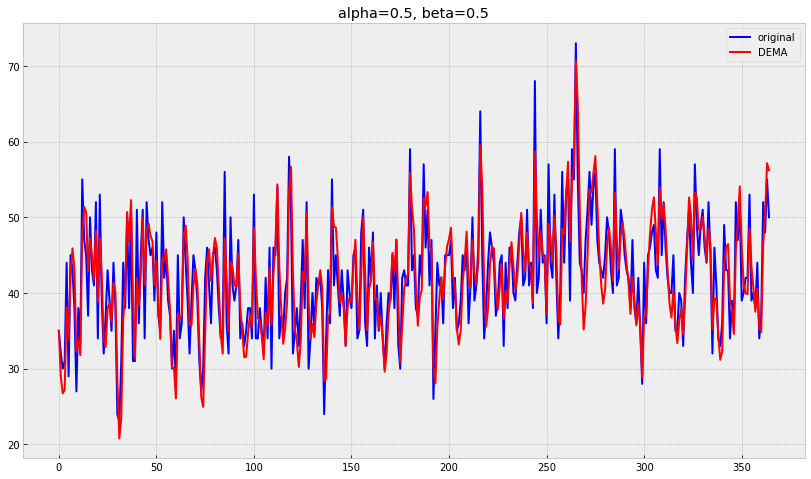

In [17]:
plot_dema(series, 0.5, 0.5)

In [18]:
opt = minimize(dema_mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [19]:
opt

      fun: 0.26735739534991565
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.76920717e-06, -3.05866443e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 69
      nit: 16
   status: 0
  success: True
        x: array([0.97260973, 0.06039859])

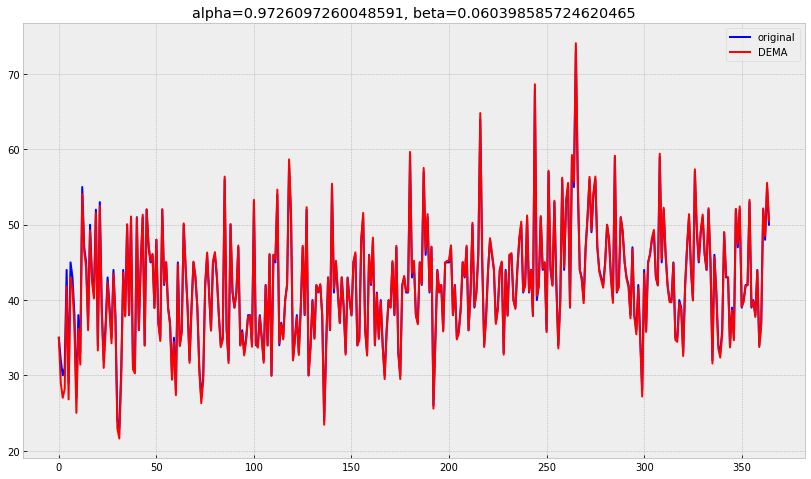

In [20]:
plot_dema(series, opt.x[0], opt.x[1])

In [21]:
print("RMSE:", opt.fun)

RMSE: 0.26735739534991565
